## figures bookmarks

Go to Bookmark <a href=#many_simulations>many_simulations</a>

Go to Bookmark <a href=#higher_order_stats>higher_order_stats</a>


Go to Bookmark <a href=#avb_ava_sim>avb_ava_sim</a>





Go to Bookmark <a href=#intrinsic_neuron_pulse>intrinsic_neuron_pulse</a>


### Run many simulations and compute higher order stats, test with and without EJ and Syn

In [17]:
using DifferentialEquations
using Statistics

using LinearAlgebra
using DifferentialEquations, Plots
using Statistics
using SparseArrays

using JSON
using LinearAlgebra
using SavitzkyGolay
using Plots
using LaTeXStrings

using StatsPlots
using Statistics

using DataInterpolations

using SciMLBase
using OrdinaryDiffEq

In [19]:
#################################
#### load saved functions  ######
#################################

include("functions\\functions_regression.jl")
######### contains functions .. #########
## RELU
## Data_Replacement

include("functions\\functions_simulation.jl")
######### contains functions .. #########
## lorenz!
## moving_average
## heaviside_pulse


heaviside_pulse (generic function with 1 method)

## load processed White graph data

In [21]:
using DataFrames
using CSV

data_folder = "data/White_data_processed"
filename = "df5.csv"
filepath = joinpath(data_folder, filename);
df5 = DataFrame(CSV.File(filepath));

############################################
### take processed data from White #########
############################################

out_set = collect(Set(df5[!, :"Neuron2"]))
in_set = collect(Set(df5[!, :"Neuron1"]))
final_neurons = union(out_set, in_set)
N = size(final_neurons)[1]  ## number of neurons in my model
final_neuron_dict = Dict(zip(final_neurons, collect(1:N)))

#############################
### make EJ matrix ##########
#############################
df_EJ = filter(row -> row."Type" == "EJ",df5) # df_subset
EJ_mat = zeros(N,N)
for i in collect(1:size(df_EJ,1))
    w_tmp = df_EJ[i,:]["Nbr"]
    neuro1 = df_EJ[i,:]["Neuron1"]
    neuro2 = df_EJ[i,:]["Neuron2"]
    id1 = final_neuron_dict[neuro1]
    id2 = final_neuron_dict[neuro2]
    EJ_mat[id1, id2] = w_tmp
end

#############################
### make Syn matrix #########
#############################
df_S = filter(row -> row."Type" == "S",df5) # df_subset
S_mat = zeros(N,N)

for i in collect(1:size(df_S,1))
    w_tmp = df_S[i,:]["Nbr"]
    neuro1 = df_S[i,:]["Neuron1"]
    neuro2 = df_S[i,:]["Neuron2"]
    id1 = final_neuron_dict[neuro1]
    id2 = final_neuron_dict[neuro2]
    S_mat[id1, id2] = w_tmp
end

S_mat = S_mat'; # transpose for matrix multiplication
S_mat_bool = S_mat .!=0;

## Simulate core neurons using avg regression weights
### (avg weights computed from compute_avg_weights.ipynb)

In [25]:
using JLD2

data_folder = "data/model_weights"
filename = "avg_model_weights.jld2"
filepath = joinpath(data_folder, filename);


#@save filepath A_10takes_avg d_10takes_avg
@load filepath A_10takes_avg d_10takes_avg


2-element Vector{Symbol}:
 :A_10takes_avg
 :d_10takes_avg

### finds highly correlated neurons

In [27]:
##########################################
### find higherly correlated neurons,  ###
### use these neurons as candidate     ###
### replacements when neuron is missing ##
##########################################

data_folder = "data\\Atanas_data"

fn1 = "2023-03-07-01.json"
fn2 = "2023-01-23-21.json"
fn3 = "2023-01-23-15.json"  # avb (use for test?)
fn4 = "2023-01-19-22.json"
fn5 = "2023-01-19-15.json" # avb
fn6 = "2023-01-19-08.json" # avb
fn7 = "2023-01-19-01.json" # avb
fn8 = "2023-01-17-14.json"
fn9 = "2023-01-17-07.json"
fn10 = "2023-01-16-22.json" #avb, heat
fn11 = "2023-01-16-15.json"
fn12 = "2023-01-16-08.json" #avb, heat
fn13 = "2023-01-10-14.json" #avb, heat  
fn14= "2023-01-10-07.json"  #avb, heat
fn15 = "2023-01-09-28.json"
fn16 = "2023-01-09-22.json"
fn17 = "2023-01-09-15.json"
fn18 = "2023-01-09-08.json" #avb, heat
fn19 = "2023-01-06-15.json"
fn20 = "2023-01-06-08.json"
fn21 = "2023-01-06-01.json"
fn22 = "2023-01-05-18.json" #avb, heat
fn23 = "2023-01-05-01.json"
fn24 = "2022-12-21-06.json"
fn25 = "2022-08-02-01.json"
fn26 = "2022-07-20-01.json"
fn27 = "2022-06-28-07.json"
fn28= "2022-06-28-01.json"
fn29 = "2022-06-14-13.json"
fn30 = "2022-06-14-07.json"

all_filenames = [fn1, fn2, fn3, # skip fn3
     fn4, fn5, fn6, fn7, fn8, fn9, fn10,
                fn11, fn12, fn13,  
    fn14, fn15, fn16, fn17, fn18, fn19, fn20,
                fn21, fn22, fn23, fn24, fn25, fn26, fn27, fn28, fn29, fn30]

num_files = size(all_filenames)[1]

cor_store = zeros(N, num_files)
fname_counter = 1

for fname in all_filenames
    filepath1 = joinpath(data_folder, fname);
    Fdata1 = JSON.parsefile(filepath1)
    labs = Fdata1["labeled"]
    Fts1 = Fdata1["trace_array"]
    key_set = keys(labs)
    Dict_nms = Dict{String,Int}()
    for ky in key_set
        Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
    end
    names_have = keys(Dict_nms);
    
    i = 1 # counter
    for nm in final_neurons
        ## get two L/R ts to compare ##
        if nm in(names_have)
            ts_tmp1 = Fts1[Dict_nms[nm]]  
            ###### normal length 4 neurons #######
            if length(nm) == 4
                nm_new = [] # put new name in
                if string(nm[4]) == "L"
                    nm_new = string(nm[1:3])*string("R")
                elseif string(nm[4]) == "R"
                    nm_new = string(nm[1:3])*string("L")
                end
                if nm_new in(names_have)
                    #println(nm_new)
                    ts_tmp2 = Fts1[Dict_nms[nm_new]]
                    cor_tmp = cor(ts_tmp1, ts_tmp2) ## compute corelation between two timeseries
                    cor_store[i,fname_counter] = cor_tmp ## put correlation in storage
                end
            end
            ###### end length 4 neurons #######
            ###### length 5 neurons #######
            if length(nm) == 5
                nm_new = [] # put new name in
                if string(nm[5]) == "L"
                    nm_new = string(nm[1:4])*string("R")
                elseif string(nm[5]) == "R"
                    nm_new = string(nm[1:4])*string("L")
                end
                if nm_new in(names_have)
                    #println(nm_new)
                    ts_tmp2 = Fts1[Dict_nms[nm_new]]
                    cor_tmp = cor(ts_tmp1, ts_tmp2) ## compute corelation between two timeseries
                    cor_store[i,fname_counter] = cor_tmp ## put correlation in storage
                end
            end
            ###### end length 5 neurons #######
        end
        i+=1 
    end
    fname_counter+=1
end

cor_mean_list = zeros(N)
for i in collect(1:N)
    tmp_row = cor_store[i,:]
    if sum(tmp_row) !=0
        idx_tmp = findall(tmp_row.!=0)
        cor_vals_tmp = tmp_row[idx_tmp]
        cor_mean_list[i]=mean(cor_vals_tmp)
    end
end

###############################################
## final list of highly correlated neurons ####
###############################################
highly_correlated_neurons = final_neurons[findall(cor_mean_list.>0.7)]; # 75

##########################################################
## use this list and "AVB" pair to make substitutions ####
##########################################################

switchout_list = append!(["AVBL", "AVBR"], highly_correlated_neurons);


# simulate premotor dynamics, many simulations

Bookmark many_simulations <a name='many_simulations' />

## ODE

$ \tau \frac{dx}{dt} = -2*(u-fp1)(u-fp2)(u-fp3) + d + 1.4*Syn + 10* EJ$

In [29]:
###########################
###### ODE function #######
###########################
function lorenz!(du,u,p,t)
    γ, β, τ = p
    #### get the current signal ####
    usig_tmp = []
    for j in collect(1:Nsignals)
        append!(usig_tmp,Dsigs_interp[j](t))
    end
    
    #### put both the intrinsic and signal into single vector ####
    utmp = zeros(Ncore)
    utmp[ids_intrinsic] = u  #put in current intrinsic timepoints
    utmp[ids_signal] = usig_tmp
    du_tmp = zeros(Ncore)
    ublockT = transpose(repeat(utmp, 1, Ncore))
    ublock = repeat(utmp, 1, Ncore)
    #A_u = A*u
    A_RELUu = A*Relu.(utmp) # use instead of A_u
    W_u = diag(W*(ublock - ublockT))
    for j in collect(1:Ncore)
        ########### divide by global timescale variable tau ############
         du_tmp[j] = (1/τ)*(a*(utmp[j].-fp1).*(utmp[j].-fp2).*(utmp[j].-fp3) + d[j] + γ*A_RELUu[j] + β*W_u[j]) # fps version
    end
    
    du_tmp = du_tmp[ids_intrinsic]  # JUST output the derivative for the intrinsic neurons!
    for j in collect(1:Nintrinsic)
        #du[j] = -1*u[j] + Dsigs_interp[j](t)
        du[j] = du_tmp[j]
    end
end

lorenz! (generic function with 1 method)

### simulation setup data

In [36]:
###############################################
## use all of these for PLOS comp bio  ########
###############################################
#fn = "2023-01-09-08.json"  # USE THIS for PLOS comp bio
#fn = "2023-01-10-07.json"  # USE THIS for PLOS comp bio
#fn = "2023-01-23-21.json" # USE THIS for PLOS comp bio
#fn = "2023-01-05-01.json"  # USE THIS for PLOS comp bio
#fn = "2023-01-09-15.json"  # USE THIS for PLOS comp bio - "roaming"
#fn = "2023-01-09-22.json"   # USE THIS for PLOS comp bio - "dwelling"

#####  main dataset  ########
fn = "2023-01-23-15.json"  
date_string =fn[1:13]
################################

data_folder = "data\\Atanas_data"
filepath1 = joinpath(data_folder, fn); # make sure and change this!
Fdata1 = JSON.parsefile(filepath1)
labs = Fdata1["labeled"]
Fts1 = Fdata1["trace_array"]
dt = round(Fdata1["avg_timestep"]; digits = 3)
dFts1dt = copy(0*Fts1)

#########################
####  smooth data  ######
#########################
for i in collect(1:size(Fts1)[1])
    ts_tmp = savitzky_golay(Fts1[i], 11, 5).y;
    #ts_tmp = savitzky_golay(Fts1[i], 21, 7).y;
    ts_tmp_chop1 = ts_tmp[3:end]
    ts_tmp_chop2 = ts_tmp[1:end-2]
    dts_dt_tmp = (ts_tmp_chop1 - ts_tmp_chop2)/(2*dt)
    ts_tmp_mid = ts_tmp[2:end-1]
    Fts1[i] = ts_tmp_mid
    dFts1dt[i] = dts_dt_tmp
end
key_set = keys(labs)
Dict_nms = Dict{String,Int}()
for ky in key_set
    Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
end
names_have = keys(Dict_nms);
ts_len = size(Fts1[1])[1]

#########################################################################################################
### Go though list of model neurons, see what model neurons there are timeseries for and collect ts #####
#########################################################################################################
ts_myneuros = zeros(N,ts_len)
dtsdt_myneuros = zeros(N,ts_len)

##################
##################

i = 1 # counter
for nm in final_neurons
    if nm in(names_have)
        ts_myneuros[i,:] = Fts1[Dict_nms[nm]]  
        dtsdt_myneuros[i,:] = dFts1dt[Dict_nms[nm]]      
    ###############################
    ## ADD in DATA REPLACEMENT ##
    ##############################
    else
        #Data_Replacement(nm)
        Data_Replacement(i, nm, names_have, switchout_list, Dict_nms, ts_myneuros, dtsdt_myneuros, Fts1, dFts1dt)
    end
    i+=1 # move on to the next row
end


##########################
## Pre for regression ####
##########################
D = copy(ts_myneuros)  # timeseries of all neurons in order of "final_neurons" (many rows zero, no data for them)
dDdt = copy(dtsdt_myneuros)  # derivative timeseries

##########################
#### get short D matrix ##
##########################
row_sum = sum(D, dims = 2)
idxfull_list = Int64[]
for i in collect(1:size(row_sum)[1])
    if row_sum[i] != 0
        append!(idxfull_list, i)  # get index of nonzero rows (aka final_neurons that have a timeseries)
    end  
end

Dshort = D[idxfull_list,:] # only the rows with nonzero timeseries
dDdtshort = dDdt[idxfull_list,:]  # only the rows with nonzero timeseries

println("num neurons ts = ", size(idxfull_list)[1]) # number of final_neurons that have a timeseries

##################################################
## get submatrices with only core (ts) neurons ###
##################################################
EJ_mat_short = EJ_mat[idxfull_list,idxfull_list]
S_mat_short = S_mat[idxfull_list,idxfull_list]
N_short = size(idxfull_list)[1]

#########################################################
## core neurons - named and timeseries - short block ####
#########################################################
core_neurons = final_neurons[idxfull_list]  # core neurons are all neurons with ts for current dataset
Ncore = size(core_neurons)[1]
ids_core = []
for i in collect(1:Ncore)
    append!(ids_core, final_neuron_dict[core_neurons[i]])
end
Dcore = D[ids_core,:]
dDdtcore = dDdt[ids_core,:]
core_neurons_dict = Dict(zip(core_neurons, collect(1:Ncore)));

##################################
## put in regressed Syn signs ####
##################################
S_approx = A_10takes_avg # use the average for 30 datasets
d_approx = d_10takes_avg; # use the average for 30 datasets



switchout SMBDL
switchout AVBR
AVBL
switchout RIBR
RIBL
switchout AVKR
switchout AVKL
switchout SMBVL
switchout SMBVR
switchout BAGL
switchout SMBDR
switchout BAGR
num neurons ts = 84


### run simulation

In [38]:
######################
###  PARAMETERS  ####
######################
## fps at 0, 0.4, 0.8
fp1 = -0.8
fp2 = 0.1
fp3 = 1.0

a = -2    #  a = -2
γ = 1.4   #  γ = 1.4  
β = 10    #  β = 10 
τ = 0.2   #  τ = 0.1



d = d_approx[ids_core]
A = S_approx[ids_core,ids_core] 
W = EJ_mat[ids_core,ids_core]

######################
######################

##########################
## feed in signals #######
##########################
time_vec = collect(0:dt:100)

############################
#####  complete set  #######
############################
intrinsic_neurons = ["AVBL","AVBR","RIBL","RIBR","RID", "AVDL", "AVDR",
    "AVAL", "AVAR", "RIML", "RIMR",
"AVEL","AVER","AIBL","AIBR"]

clrsp = palette(:batlow10)
clrs = [clrsp[2], clrsp[2], clrsp[2], clrsp[2], clrsp[2], clrsp[4], clrsp[4],
    clrsp[7], clrsp[7], clrsp[7], clrsp[7], clrsp[7], clrsp[7], clrsp[7], clrsp[7]]

ids_intrinsic = []
for i in collect(1:size(intrinsic_neurons)[1])
    append!(ids_intrinsic,core_neurons_dict[intrinsic_neurons[i]])
end
Nintrinsic = size(ids_intrinsic)[1]
ids_signal = setdiff(collect(1:Ncore), ids_intrinsic) # signal neurons ids
Nsignals = size(ids_signal)[1]

##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]
Dsignals = Dcore_cut[ids_signal,:]
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400 
t_short = dt*collect(0:num_steps)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)

sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);




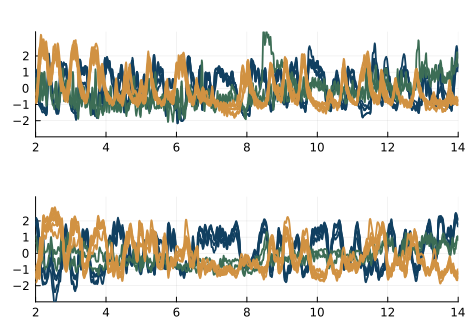

"figures/simulations/sim_2023-01-23-15.pdf"

In [40]:
################################################
## plot results of simulation versus data  #####
################################################

t_id_st = 201  # time to start plot
########################
#### plot real TS ######
########################
p1 = plot(title = " ",ytick = -2:1:2, xlim = (time_vec[t_id_st],14), ylim = (-3,3.5))
for i in 1:size(Dintrinsic,1)
    plot!(time_vec[t_id_st:num_steps+1], Dintrinsic[i,t_id_st:num_steps+1], label = false, color = clrs[i], linewidth = 1.8) #label = intrinsic_neurons[i]
end

########################
#### plot simulation ######
########################
p2 = plot(title = " ",ytick = -2:1:2, xlim = (time_vec[t_id_st],14), ylim = (-3,3.5))
for i in collect(1:Nintrinsic)
    #plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8)
plot!(sol_EJ_Syn.t[t_id_st:end], sol_EJ_Syn[i,t_id_st:end], label = false, color = clrs[i], linewidth = 1.8)
end

######################################################
### Behavioral timeseries of data and simulation #####
######################################################

F_data_ts = mean(Dintrinsic[1:5,1:num_steps+1],dims = 1)
R_data_ts = mean(Dintrinsic[8:13,1:num_steps+1],dims = 1)

thresh = 0.5

z_data_ts = F_data_ts - R_data_ts
z_data_ts[z_data_ts.> thresh] .= 1
z_data_ts[z_data_ts.< -thresh] .= -1
z_data_ts[(z_data_ts .> -thresh).*(z_data_ts .< thresh)] .=0
behav_ts = sign.(z_data_ts)


F_sim_ts = mean(sol_EJ_Syn[1:5,1:num_steps+1],dims = 1) 
R_sim_ts = mean(sol_EJ_Syn[8:13,1:num_steps+1],dims = 1)
z_sim_ts = F_sim_ts - R_sim_ts
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)
######################################################
######################################################


pall = plot(p1,p2, layout = (2,1), size = (470,330)) # size = (700,330), #size = (700,300)

display(pall)



## behavioral ts

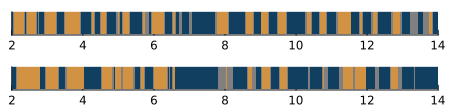

In [42]:
######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:7]
c1[3] = :grey
c1[4] = :grey

p1 = plot(heatmap(time_vec[t_id_st:num_steps+1],[1],-1*behav_ts[:,t_id_st:num_steps+1],c =c1, clim = (-1,1), xlim = (time_vec[t_id_st],14), ytick = false, legend=:none), size = (500,100)) # size = (700,100)
p2 = plot(heatmap(time_vec[t_id_st:num_steps+1], [1], -1*behav_ts_sim[:,t_id_st:num_steps+1], c = c1, clim = (-1,1), xlim = (time_vec[t_id_st],14), ytick = false, legend=:none), size = (500,100)) #size = (700,100)

pall = plot(p1,p2, layout = (2,1), size = (450,110))  #size = (675,110)
display(pall)



## Higher-order stats on simulation,  fn = "2023-01-23-15.json"

Bookmark higher_order_stats <a name='higher_order_stats' />

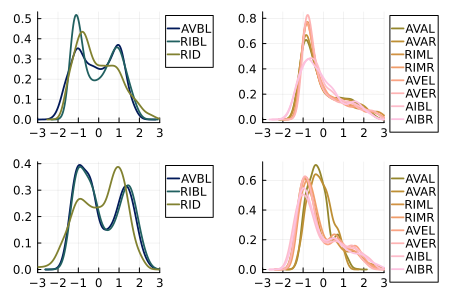

In [44]:

clrs = palette(:batlow25)
clrs_F = clrs[[1,4,7,10,13]]  ## AVB clr set ##
clrs_R = clrs[[14,16,17,19, 20, 22,23,24]]  ## AVA clr set ##
    

p1 = density(Dcore[core_neurons_dict["AVBL"],t_id_st:num_steps+1], label="AVBL", xlim = (-3,3),
    legend=:outertopright, linewidth = 1.8, color = clrs_F[1])
p1 = density!(Dcore[core_neurons_dict["RIBL"],t_id_st:num_steps+1], label = "RIBL", linewidth = 1.8, color = clrs_F[3])
p1 = density!(Dcore[core_neurons_dict["RID"],t_id_st:num_steps+1], label = "RID", linewidth = 1.8, color = clrs_F[5])

# p2 = density(Dcore[core_neurons_dict["AVDL"],:], label = "AVDL", linewidth = 1.8, color = clrs[1])
# p2 = density!(Dcore[core_neurons_dict["AVDR"],:], label = "AVDR", linewidth = 1.8, color = clrs[5])

p3 = density(Dcore[core_neurons_dict["AVAL"],t_id_st:num_steps+1], label = "AVAL", xlim = (-3,3), 
    legend=:outertopright, linewidth = 1.8, color = clrs_R[1])
p3 = density!(Dcore[core_neurons_dict["AVAR"],t_id_st:num_steps+1], label = "AVAR", linewidth = 1.8, color = clrs_R[2])
p3 = density!(Dcore[core_neurons_dict["RIML"],t_id_st:num_steps+1], label = "RIML", linewidth = 1.8, color = clrs_R[3])
p3 = density!(Dcore[core_neurons_dict["RIMR"],t_id_st:num_steps+1], label = "RIMR", linewidth = 1.8, color = clrs_R[4])
p3 = density!(Dcore[core_neurons_dict["AVEL"],t_id_st:num_steps+1], label = "AVEL", linewidth = 1.8, color = clrs_R[5])
p3 = density!(Dcore[core_neurons_dict["AVER"],t_id_st:num_steps+1], label = "AVER", linewidth = 1.8, color = clrs_R[6])
p3 = density!(Dcore[core_neurons_dict["AIBL"],t_id_st:num_steps+1], label = "AIBL", linewidth = 1.8, color = clrs_R[7])
p3 = density!(Dcore[core_neurons_dict["AIBR"],t_id_st:num_steps+1], label = "AIBR", linewidth = 1.8, color = clrs_R[8])

# p3 = density(Dcore[core_neurons_dict["ASHL"],:], label = "ASHL")
# p3 = density!(Dcore[core_neurons_dict["URXL"],:], label = "URXL")
# p3 = density!(Dcore[core_neurons_dict["FLPL"],:], label = "FLPL")
# p3 = density!(Dcore[core_neurons_dict["AQR"],:], label = "AQR")

p4 = density(sol_EJ_Syn[1,t_id_st:num_steps+1], label="AVBL", xlim = (-3,3), legend=:outertopright, linewidth = 1.8, color = clrs_F[1])
p4 = density!(sol_EJ_Syn[2,t_id_st:num_steps+1], label="RIBL", linewidth = 1.8, color = clrs_F[3])
p4 = density!(sol_EJ_Syn[3,t_id_st:num_steps+1], label="RID", linewidth = 1.8, color = clrs_F[5])


# p5 = density(sol_EJ_Syn[4,:], label="AVDL", linewidth = 1.8, color = clrs[1])
# p5 = density!(sol_EJ_Syn[5,:], label="AVDR", linewidth = 1.8, color = clrs[5])

p6 = density(sol_EJ_Syn[6,t_id_st:num_steps+1], label="AVAL", xlim = (-3,3), legend=:outertopright, linewidth = 1.8, color = clrs_R[1])
p6 = density!(sol_EJ_Syn[7,t_id_st:num_steps+1], label="AVAR", linewidth = 1.8, color = clrs_R[2])
p6 = density!(sol_EJ_Syn[8,t_id_st:num_steps+1], label="RIML", linewidth = 1.8, color = clrs_R[3])
p6 = density!(sol_EJ_Syn[9,t_id_st:num_steps+1], label="RIMR", linewidth = 1.8, color = clrs_R[4])
p6 = density!(sol_EJ_Syn[10,t_id_st:num_steps+1], label="AVEL", linewidth = 1.8, color = clrs_R[5])
p6 = density!(sol_EJ_Syn[11,t_id_st:num_steps+1], label="AVER", linewidth = 1.8, color = clrs_R[6])
p6 = density!(sol_EJ_Syn[12,t_id_st:num_steps+1], label="AIBL", linewidth = 1.8, color = clrs_R[7])
p6 = density!(sol_EJ_Syn[13,t_id_st:num_steps+1], label="AIBR", linewidth = 1.8, color = clrs_R[8])

pall = plot(p1,p3,p4, p6, layout = (2,2), size = (450,300))  # size = (800,300)
display(pall)




In [48]:
using Colors
using Plots

# Define the color array
#color_array = ["785964","856b72","917d80","9e8f8e","aaa19c","b7b2ab","c3c4b9","d0d6c7","dce8d5","e9fae3"]

color_array = ["160c28","2d2539","433f4b","5a585c","70716d","878b7f","9da490","b4bda1","cad7b3","e1f0c4"]

# Convert hexadecimal colors to RGB colors
rgb_colors = [parse(RGB, "#" * color) for color in color_array]

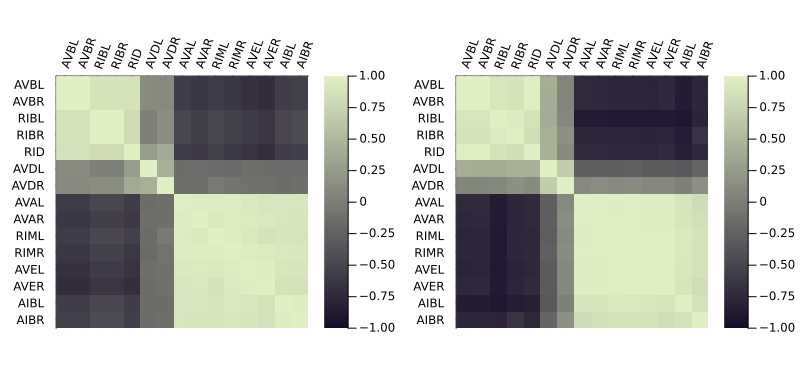

In [50]:
#####################################
#####  correlation matrices   #######
#####################################
cor_mat = cor(Dcore[ids_intrinsic,t_id_st:num_steps+1]')

p1 = plot(heatmap(intrinsic_neurons,intrinsic_neurons,cor_mat, 
                c =rgb_colors,
aspect_ratio=:equal,
            yflip = true,
            xrotation = 70,
            xmirror = true, clim = (-1,1)))


p2 =plot(heatmap(intrinsic_neurons, intrinsic_neurons,cor(sol_EJ_Syn[:,t_id_st:num_steps+1]'),
            c =rgb_colors,
aspect_ratio=:equal,
            yflip = true,
            xrotation = 70,
            xmirror = true, clim = (-1,1)))

pall = plot(p1, p2, layout = (1,2), size = (800,380))
display(pall)



## Histograms of dwell times

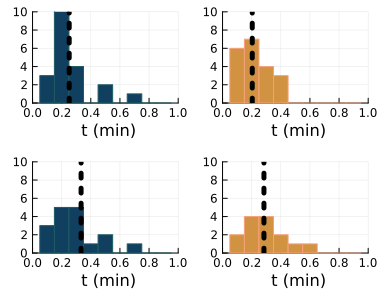

data F = 0.25173913043478263
sim F = 0.3333333333333333
data R = 0.20400000000000001
sim R = 0.2842857142857143


In [52]:
## function that counts the number of repeats in a list
function count_repeat_ones(arr::AbstractArray{Int})
    repeat_lengths = Int[]

    count = 0
    for i in 1:length(arr)
        if arr[i] == 1
            count += 1
        elseif count > 0
            push!(repeat_lengths, count)
            count = 0
        end
    end

    if count > 0
        push!(repeat_lengths, count)
    end

    return repeat_lengths
end

mint = 3/60
# t_id_st = 201  # time to start plot, make sure this is the same as above!
# num_steps = 1400 # make sure this is the same as above!

rev_ts = Int.(vec(behav_ts[t_id_st:num_steps+1].<0))
for_ts = Int.(vec(behav_ts[t_id_st:num_steps+1].>0))

rev_ts_sim = Int.(vec(behav_ts_sim[t_id_st:num_steps+1].<0))
for_ts_sim = Int.(vec(behav_ts_sim[t_id_st:num_steps+1].>0))

dwell_times_data_R = dt*count_repeat_ones(rev_ts)
dwell_times_data_R = dwell_times_data_R[dwell_times_data_R.> mint]

dwell_times_data_F = dt*count_repeat_ones(for_ts)
dwell_times_data_F = dwell_times_data_F[dwell_times_data_F.> mint]

dwell_times_sim_R = dt*count_repeat_ones(rev_ts_sim)
dwell_times_sim_R = dwell_times_sim_R[dwell_times_sim_R.> mint]

dwell_times_sim_F = dt*count_repeat_ones(for_ts_sim)
dwell_times_sim_F = dwell_times_sim_F[dwell_times_sim_F.> mint]

#######################################################
#######################################################
#########        FINAL FIG          ###################
#######################################################
#######################################################

#######################################################
########    histograms of switch times  ###############
#######################################################
clrsp = palette(:batlow10)

x_max = 1.0  # 1.3 for 2023-01-23-15.json

p1 = histogram(dwell_times_data_F, bins = mint:0.1:x_max, xticks = 0:0.2:x_max, xlabel = " t (min)", color = clrsp[2],  linecolor = clrsp[3], 
    xlim = (0,x_max), ylim = (0,10), legend = false) # ylabel = "freq", title = "data F", ylim = (0,13)
p1 = vline!([mean(dwell_times_data_F)], linestyle =:dot, linewidth = 5, color = "black")

p2 = histogram(dwell_times_data_R, bins = mint:0.1:x_max, xticks = 0:0.2:x_max, xlabel = " t (min)", color = clrsp[7],  linecolor = clrsp[8], 
    xlim = (0,x_max), ylim = (0,10), legend = false)  # ylabel = "freq",  title = "data R",  ylim = (0,13)
p2 = vline!([mean(dwell_times_data_R)], linestyle =:dot, linewidth = 5, color = "black")

p3 = histogram(dwell_times_sim_F, bins = mint:0.1:x_max, xticks = 0:0.2:x_max, xlabel = " t (min)", color = clrsp[2],  linecolor = clrsp[3], 
    xlim = (0,x_max), ylim = (0,10), legend = false)  # ylabel = "freq", title = "sim F", ylim = (0,8)
p3 = vline!([mean(dwell_times_sim_F)], linestyle =:dot, linewidth = 5, color = "black")


p4 = histogram(dwell_times_sim_R, bins = mint:0.1:x_max, xticks = 0:0.2:x_max, xlabel = " t (min)", color = clrsp[7], linecolor = clrsp[8], 
    xlim = (0,x_max), ylim = (0,10), legend = false) # ylabel = "freq", title = "sim R", ylim = (0,8)
p4 = vline!([mean(dwell_times_sim_R)], linestyle =:dot, linewidth = 5, color = "black")

# p1 = histogram(wt_dxdt_F_intrinsic, bins = -5:4:80, title = "intrinsic")
# p2 = histogram(wt_dxdt_F2F, bins = 0:4:80, title = "FSyn")
# p3 = histogram(wt_dxdt_F_intrinsic + wt_dxdt_F2F, bins = -5:4:80, title = "both")

pall = plot(p1, p2, p3, p4, layout = (2,2), size = (380,300))  # size = (350,300)
display(pall)



println("data F = ", mean(dwell_times_data_F))
println("sim F = ", mean(dwell_times_sim_F))

println("data R = ", mean(dwell_times_data_R))
println("sim R = ", mean(dwell_times_sim_R))

## Make petri dish simulation

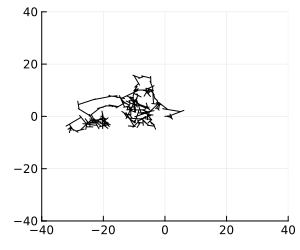

In [54]:

x0 = [0, 0]

nf = 200

x_vec = zeros(2,2*nf+1)
ct = 0
theta = 0

for i in range(1,nf)
    ct = ct+1
    # select an angle for turn
    ## select omega turn 0.35 or regular turn 0.65
    omega_reg = rand()
    
    if omega_reg < 0.35 # omega turn, pull from omega distribution
        delta_theta = pi*rand() + pi/2
    else  # regular turn, pull from regular distribution
        delta_theta = pi*rand() - pi/2
    end
    
    theta = theta + delta_theta
    
    # go foward
    tf = rand(dwell_times_data_F)
    tf = tf*60 # turn minutes to seconds
    speedf = 0.15 # mm/sec
    x = tf*speedf*cos(theta)
    y = tf*speedf*sin(theta)
    
    # compute location at end of foward run
    x_vec[:,ct+1] = x_vec[:,ct] + [x;y]
    ct = ct+1

    tr = rand(dwell_times_data_R)
    speedr = 0.075 #mm/sec 
    tr = tr*60 # turn minutes to seconds
    x = -tr*speedr*cos(theta)
    y = -tr*speedr*sin(theta)
    
    # compute location at end of reversal
    x_vec[:,ct+1] = x_vec[:,ct] + [x;y]
    
    #println(theta)
end

p1 = plot(x_vec[1,:], x_vec[2,:], c = :black, xlim =(-40,40), ylim = (-40,40), legend = false, size = (300,250)) #size = (250,150)
display(p1)
    

## Petri dish sim, real path

In [56]:
#######################################
####  Define colors for pulse  ########
#######################################
color_array_pulse = ["7FD8BE","995d81", "758ECD", "FFD449", "E2C2FF"]
rgb_colors_pulse = [parse(RGB, "#" * color) for color in color_array_pulse]

In [58]:
#############################
###  pre-process data  ######
#############################
bts = behav_ts[:,t_id_st:num_steps+1]'
bts_seq = zeros(0)
append!(bts_seq,bts[1])

bts_count=zeros(0)
ct = 1

for i in range(2,length(bts))  # length(bts)
    if bts[i] != bts[i-1]
        append!(bts_seq, bts[i])
        append!(bts_count, ct)
        ct=1
    else
        ct = ct+1
    
    end
end
append!(bts_count, ct);

## Locomotion simulation

In [60]:
#############################
###  petri dish sim  ######
#############################

x0 = [0, 0]
x02 = [-20, 0]
x03 = [20, 0]
x_vec = zeros(2,length(bts_seq)+1)
x_vec2 = zeros(2,length(bts_seq)+1)
x_vec3 = zeros(2,length(bts_seq)+1)

x_vec2[:,1] = x02
x_vec3[:,1] = x03

theta = 0
theta2 = 0
theta3 = 0

for i in range(1,length(bts_seq))
    current_behav = bts_seq[i]
    
    if current_behav == 1  # forward
        # go foward
        tf = bts_count[i]*dt
        tf = tf*60 # turn minutes to seconds
        speedf = 0.15 # mm/sec
        # first path
        x = tf*speedf*cos(theta)
        y = tf*speedf*sin(theta)
        # compute location at end of foward run
        x_vec[:,i+1] = x_vec[:,i] + [x;y]
        
        # second path
        x2 = tf*speedf*cos(theta2)
        y2 = tf*speedf*sin(theta2)
        # compute location at end of foward run
        x_vec2[:,i+1] = x_vec2[:,i] + [x2;y2]
        
        # third path
        x3 = tf*speedf*cos(theta3)
        y3 = tf*speedf*sin(theta3)
        # compute location at end of foward run
        x_vec3[:,i+1] = x_vec3[:,i] + [x3;y3]
        
    elseif current_behav == -1  # reversal THEN TURN
        # go reversal
        tr = bts_count[i]*dt
        tr = tr*60 # turn minutes to seconds
        speedr = 0.075 #mm/sec 
        x = -tr*speedr*cos(theta)
        y = -tr*speedr*sin(theta)
        # compute location at end of reversal
        x_vec[:,i+1] = x_vec[:,i] + [x;y]
        
        # second path
        x2 = -tr*speedr*cos(theta2)
        y2 = -tr*speedr*sin(theta2)
        # compute location at end of reversal
        x_vec2[:,i+1] = x_vec2[:,i] + [x2;y2]
        
        # third path
        x3 = -tr*speedr*cos(theta3)
        y3 = -tr*speedr*sin(theta3)
        # compute location at end of reversal
        x_vec3[:,i+1] = x_vec3[:,i] + [x3;y3]
        
        # now turn
        # select an angle for turn
        ## select omega turn 0.35 or regular turn 0.65
        omega_reg = rand()
        if omega_reg < 0.35 # omega turn, pull from omega distribution
            delta_theta = pi*rand() + pi/2
        else  # regular turn, pull from regular distribution
            delta_theta = pi*rand() - pi/2
        end
        theta = theta + delta_theta
        
        # SECOND TURN
        # select an angle for turn
        ## select omega turn 0.35 or regular turn 0.65
        omega_reg2 = rand()
        if omega_reg2 < 0.35 # omega turn, pull from omega distribution
            delta_theta2 = pi*rand() + pi/2
        else  # regular turn, pull from regular distribution
            delta_theta2 = pi*rand() - pi/2
        end
        theta2 = theta2 + delta_theta2
        
        # THIRD TURN
        # select an angle for turn
        ## select omega turn 0.35 or regular turn 0.65
        omega_reg3 = rand()
        if omega_reg3 < 0.35 # omega turn, pull from omega distribution
            delta_theta3 = pi*rand() + pi/2
        else  # regular turn, pull from regular distribution
            delta_theta3 = pi*rand() - pi/2
        end
        theta3 = theta3 + delta_theta3
        
    else  # current_behav = 0, pause
        x_vec[:,i+1] = x_vec[:,i]
        x_vec2[:,i+1] = x_vec2[:,i]
        x_vec3[:,i+1] = x_vec3[:,i]
        
    end    
end        
        

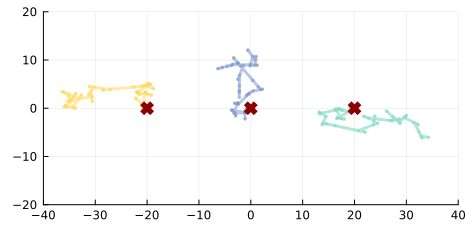

In [62]:
p1 = scatter(x_vec[1,:], x_vec[2,:], c = rgb_colors_pulse[3], markersize = 2, legend = false, alpha = 0.3, markerstrokewidth=0,
        xlim =(-40,40), ylim = (-20,20), xticks = ([-40,-30,-20,-10,0,10,20,30,40]), size = (470,230)) #size = (250,150)



p1 = plot!(x_vec[1,:], x_vec[2,:], c = rgb_colors_pulse[3], alpha =0.5, linewidth = 3)


p1 = scatter!(x_vec2[1,:], x_vec2[2,:], c = rgb_colors_pulse[4], markersize = 2, legend = false, alpha = 0.3, markerstrokewidth=0) #size = (250,150)
p1 = plot!(x_vec2[1,:], x_vec2[2,:], c = rgb_colors_pulse[4], alpha =0.5, linewidth = 3) #size = (250,150)

p1 = scatter!(x_vec3[1,:], x_vec3[2,:], c = rgb_colors_pulse[1], markersize = 2, legend = false, alpha = 0.3, markerstrokewidth=0) #size = (250,150)
p1 = plot!(x_vec3[1,:], x_vec3[2,:], c = rgb_colors_pulse[1], alpha =0.6, linewidth = 3) #size = (250,150)

st_pts = hcat(x0, x02, x03)
p1 = scatter!(st_pts[1,:], st_pts[2,:], markershape= :xcross, markerstrokewidth = 12, markerstrokecolor=:red4, color = :red4, markersize = 5)

display(p1)


## Test contribution of EJs versus Syns

## (data from simulation setup data)

Bookmark avb_ava_sim <a name='avb_ava_sim' />

In [64]:
######################
###  PARAMETERS  ####
######################
## fps at 0, 0.4, 0.8
fp1 = -0.8
fp2 = 0.1
fp3 = 1.0

a = -2 
τ = 0.2


d = d_approx[ids_core]
A = S_approx[ids_core,ids_core] 
W = EJ_mat[ids_core,ids_core]

######################
######################
##########################
## feed in signals #######
##########################
time_vec = collect(0:dt:100)

########################
## AVB neurons #########
########################
#intrinsic_neurons = ["AVBL","AVBR","RIBL", "RIBR","RID"] # for "2023-01-23-15.json"

########################
## ava neurons #########
########################
intrinsic_neurons = ["AVAL", "AVAR", "RIML", "RIMR", "AVEL","AVER", "AIBL","AIBR"]
########################

ids_intrinsic = []
for i in collect(1:Ncore)
    if core_neurons[i] in(intrinsic_neurons)
        append!(ids_intrinsic,i)
    end   
end
Nintrinsic = size(ids_intrinsic)[1]
ids_signal = setdiff(collect(1:Ncore), ids_intrinsic) # signal neurons ids
Nsignals = size(ids_signal)[1]
intrinsic_neurons = core_neurons[ids_intrinsic] # get the new order for intrinsic neurons

### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]
Dsignals = Dcore_cut[ids_signal,:]
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition


num_steps = 1400 #500
t_short = dt*collect(0:num_steps)
tspan = (0.0,t_short[end])  # timespan for the ode

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end


################################
###  only EJ connections  ###
################################
γ = 0
β = 10

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ = solve(prob,Tsit5(), saveat=t_short);

################################
## only synaptic connections ###
################################
γ = 1.4
β = 0
p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_Syn = solve(prob,Tsit5(), saveat=t_short);

#######################################
## both synaptic and EJ connections ###
#######################################
γ = 1.4       #3, 6
β = 10     #2, 5
p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);



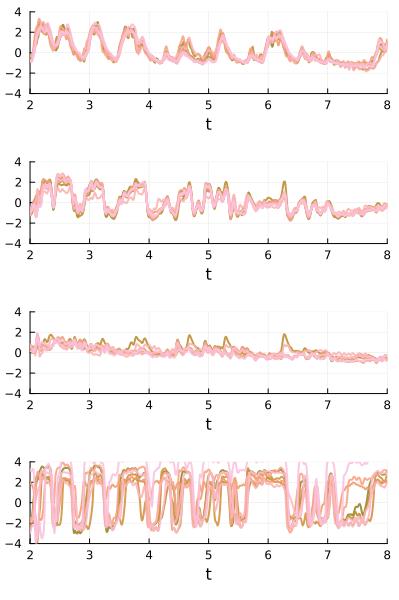

In [65]:
t_id_st = 201  # time to start plot
t_id_end = 801
##############################################
#### plot the same thing again and save  #####
##############################################
clrs = palette(:batlow25)
#clrs = clrs[[1,4,7,10,13]]  ## AVB clr set ##
clrs = clrs[[14,16,17,19, 20, 22,23,24]]  ## AVA clr set ##


p1 = plot(time_vec[t_id_st:t_id_end], Dintrinsic[1,t_id_st:t_id_end], linewidth = 2, color = clrs[1], alpha = 0.9,
    xlabel = "t", ylim = (-4,4), # ylim = (-2, 3.5)
    xlim = (time_vec[t_id_st], time_vec[t_id_end]), labels = false) #labels = intrinsic_neurons[1], labels = false, ylim = (-2.5,3)

for i in collect(2:Nintrinsic)
p1 = plot!(time_vec[t_id_st:t_id_end], Dintrinsic[i,t_id_st:t_id_end], linewidth = 2, color = clrs[i], alpha = 0.9,
        labels = false, legend=:topleft) 
    #labels = intrinsic_neurons[i], labels = false
end
#title = "data"
labels = reshape(intrinsic_neurons,(1,:)) #ylim = (-1.5,3.5)



#p2 = plot(title = " ",ytick = -2:1:2, xlim = (time_vec[t_id_st],time_vec[num_steps]), ylim = (-3,3.5))
p2 = plot(sol_EJ_Syn, idxs = (1), color = clrs[1], linewidth = 2, labels = false, alpha = 0.9,
    ylim = (-4,4), xlim = (time_vec[t_id_st], time_vec[t_id_end])) #ylim = (-2.5,3)
for i in collect(2:Nintrinsic)
p2 = plot!(sol_EJ_Syn, idxs = (i), color = clrs[i], linewidth = 2,alpha = 0.9,
     labels = false, xlim = (time_vec[t_id_st], time_vec[t_id_end])) 
end


p3 = plot(sol_EJ, idxs = (1), color = clrs[1], linewidth = 2, labels = false, alpha = 0.9, ylim = (-4,4),
    xlim = (time_vec[t_id_st], time_vec[t_id_end])) #ylim = (-2.5,3)
for i in collect(2:Nintrinsic)
p3 = plot!(sol_EJ, idxs = (i), color = clrs[i], linewidth = 2,alpha = 0.9,
     labels = false, xlim = (time_vec[t_id_st], time_vec[t_id_end])) 
end

p4 = plot(sol_Syn, idxs = (1), color = clrs[1], linewidth = 2, labels = false, alpha = 0.9, ylim = (-4,4),
    xlim = (time_vec[t_id_st], time_vec[t_id_end]))
for i in collect(2:Nintrinsic)
p4 = plot!(sol_Syn, idxs = (i), color = clrs[i], linewidth = 2,alpha = 0.9,
     labels = false, xlim = (time_vec[t_id_st], time_vec[t_id_end])) 
end

pall = plot(p1, p2,p3,p4,layout = (4,1), size = (400,600))

display(pall)


In [68]:
intrinsic_neurons

8-element Vector{String7}:
 "AVEL"
 "AIBL"
 "RIMR"
 "AVAR"
 "AVER"
 "AIBR"
 "RIML"
 "AVAL"

## core neurons simulation with random input (no longer random) and heaviside from key neurons

Bookmark intrinsic_neuron_pulse <a name ='intrinsic_neuron_pulse' />

In [70]:
#####################################
#########  two finalists   ##########
#####################################
fn = "2023-01-09-15.json"
#fn = "2023-01-09-22.json"
date_string =fn[1:13]

################################

filepath1 = joinpath( data_folder, fn); # make sure and change this!
Fdata1 = JSON.parsefile(filepath1)
labs = Fdata1["labeled"]
Fts1 = Fdata1["trace_array"]
dt = round(Fdata1["avg_timestep"]; digits = 3)
dFts1dt = copy(0*Fts1)


#########################
####  smooth data  ######
#########################
for i in collect(1:size(Fts1)[1])
    ts_tmp = savitzky_golay(Fts1[i], 11, 5).y;
    #ts_tmp = savitzky_golay(Fts1[i], 21, 7).y;
    ts_tmp_chop1 = ts_tmp[3:end]
    ts_tmp_chop2 = ts_tmp[1:end-2]
    dts_dt_tmp = (ts_tmp_chop1 - ts_tmp_chop2)/(2*dt)
    ts_tmp_mid = ts_tmp[2:end-1]
    Fts1[i] = ts_tmp_mid
    dFts1dt[i] = dts_dt_tmp
end
key_set = keys(labs)
Dict_nms = Dict{String,Int}()
for ky in key_set
    Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
end
names_have = keys(Dict_nms);
ts_len = size(Fts1[1])[1]


#########################################################################################################
### Go though list of model neurons, see what model neurons there are timeseries for and collect ts #####
#########################################################################################################
ts_myneuros = zeros(N,ts_len)
dtsdt_myneuros = zeros(N,ts_len)

##################
##################

i = 1 # counter
for nm in final_neurons
    if nm in(names_have)
        ts_myneuros[i,:] = Fts1[Dict_nms[nm]]  
        dtsdt_myneuros[i,:] = dFts1dt[Dict_nms[nm]]      
    ###############################
    ## ADD in DATA REPLACEMENT ##
    ##############################
    else
        #Data_Replacement(nm)
        Data_Replacement(i, nm, names_have, switchout_list, Dict_nms, ts_myneuros, dtsdt_myneuros, Fts1, dFts1dt)
    end
    i+=1 # move on to the next row
end


##########################
## Pre for regression ####
##########################
D = copy(ts_myneuros)  # timeseries of all neurons in order of "final_neurons" (many rows zero, no data for them)
dDdt = copy(dtsdt_myneuros)  # derivative timeseries

##########################
#### get short D matrix ##
##########################
row_sum = sum(D, dims = 2)
idxfull_list = Int64[]
for i in collect(1:size(row_sum)[1])
    if row_sum[i] != 0
        append!(idxfull_list, i)  # get index of nonzero rows (aka final_neurons that have a timeseries)
    end  
end

Dshort = D[idxfull_list,:] # only the rows with nonzero timeseries
dDdtshort = dDdt[idxfull_list,:]  # only the rows with nonzero timeseries

println("num neurons ts = ", size(idxfull_list)[1]) # number of final_neurons that have a timeseries



##################################################
## get submatrices with only core (ts) neurons ###
##################################################
EJ_mat_short = EJ_mat[idxfull_list,idxfull_list]
S_mat_short = S_mat[idxfull_list,idxfull_list]
N_short = size(idxfull_list)[1]


#########################################################
## core neurons - named and timeseries - short block ####
#########################################################
core_neurons = final_neurons[idxfull_list]  # core neurons are all neurons with ts for current dataset
Ncore = size(core_neurons)[1]
ids_core = []
for i in collect(1:Ncore)
    append!(ids_core, final_neuron_dict[core_neurons[i]])
end
Dcore = D[ids_core,:]
dDdtcore = dDdt[ids_core,:]
core_neurons_dict = Dict(zip(core_neurons, collect(1:Ncore)));

##################################
## put in regressed Syn signs ####
##################################
S_approx = A_10takes_avg # use the average for 30 datasets
d_approx = d_10takes_avg; # use the average for 30 datasets



switchout AVEL
AVER
switchout SMBDL
switchout AVBR
AVBR isn't here and doesn't have twin
switchout AWAL
AWAR
switchout AVKR
switchout URADL
URADR
switchout AVKL
switchout SMBVL
SMBVR
switchout BAGL
switchout AVBL
AVBL isn't here and doesn't have twin
switchout SMBDR
switchout BAGR
num neurons ts = 89


In [72]:
#######################
###   PARAMETERS   ####
#######################
## fps at 0, 0.4, 0.8
fp1 = -0.8
fp2 = 0.1
fp3 = 1.0

a = -2    #  a = -2
γ = 1.4   #  γ = 1.4  
β = 10    #  β = 10 
τ = 0.2   #  τ = 0.1

d = d_approx[ids_core]
A = S_approx[ids_core,ids_core] 
W = EJ_mat[ids_core,ids_core]

######################
######################

##########################
## feed in signals #######
##########################
time_vec = collect(0:dt:100)


############################
#####  complete set  #######
############################
intrinsic_neurons = ["AVBL","AVBR","RIBL","RIBR","RID", "AVDL", "AVDR",
    "AVAL", "AVAR", "RIML", "RIMR",
"AVEL","AVER","AIBL","AIBR"]

clrsp = palette(:batlow10)
clrs = [clrsp[2], clrsp[2], clrsp[2], clrsp[2], clrsp[2], clrsp[5], clrsp[5],
    clrsp[7], clrsp[7], clrsp[7], clrsp[7], clrsp[7], clrsp[7], clrsp[7], clrsp[7]]


ids_intrinsic = []
id_new_order = []
for i in collect(1:Ncore)
    if core_neurons[i] in(intrinsic_neurons)
        append!(ids_intrinsic,i)
        id_tmp = findall(x->x==core_neurons[i],intrinsic_neurons)[1]
        append!(id_new_order,id_tmp)
    end   
end
clrs_new_order = clrs[id_new_order]


Nintrinsic = size(ids_intrinsic)[1]
ids_signal = setdiff(collect(1:Ncore), ids_intrinsic) # signal neurons ids
Nsignals = size(ids_signal)[1]
intrinsic_neurons = core_neurons[ids_intrinsic] # get the new order for intrinsic neurons


### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]
Dsignals = Dcore_cut[ids_signal,:]
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition


num_steps = 800 #400 #1500
t_short = dt*collect(0:num_steps)
tspan = (0.0,t_short[end])  # timespan for the ode

Dsignals=Dsignals[:,1:num_steps+1]



# ########################
# ### heaviside pulse  ###
# ########################
ASH_ts = 1*heaviside_pulse.(collect(1:num_steps+1), num_steps/2, 2); # OLQ #ASE 7 # AWC 3 # ASH 7


####################################
#########  2023-01-09-15  ##########
####################################
id1 = core_neurons_dict["OLQVR"]
id2 = core_neurons_dict["OLQVL"]
id3 = core_neurons_dict["OLQDL"]
id4 = core_neurons_dict["OLQDR"]

# id1 = core_neurons_dict["ASEL"]
# id2 = core_neurons_dict["ASER"]

####################################
#########  2023-01-09-22  ##########
####################################

#id1 = core_neurons_dict["ASHL"]

#id1 = core_neurons_dict["AWCL"]
#id2 = core_neurons_dict["AWCR"]


id1 = indexin(id1,ids_signal)  # find core neuron id in signal id list -> this is the new index
id2 = indexin(id2,ids_signal)  # find core neuron id in signal id list -> this is the new index
id3 = indexin(id3,ids_signal)
id4 = indexin(id4,ids_signal)

## save real signals
#ASHL_real_ts = Dsignals[id1,:]
# AWCL_real_ts = Dsignals[id1,:]
# AWCR_real_ts = Dsignals[id2,:]

# ASEL_real_ts = Dsignals[id1,:]
# ASER_real_ts = Dsignals[id2,:]

OLQVR_real_ts = Dsignals[id1,:]
OLQVL_real_ts = Dsignals[id2,:]
OLQDL_real_ts = Dsignals[id3,:]
OLQDR_real_ts = Dsignals[id4,:]


Dsignals[id1,:] = ASH_ts # put the heaviside in the signal matrix
Dsignals[id2,:] = ASH_ts # put the heaviside in the signal matrix
Dsignals[id3,:] = ASH_ts
Dsignals[id4,:] = ASH_ts


####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);



In [74]:
#######################################
## both synaptic and EJ connections ###
#######################################
id_AVAL = findall(intrinsic_neurons.=="AVAL")[1]
id_AVAR = findall(intrinsic_neurons.=="AVAR")[1]

id_AVEL = findall(intrinsic_neurons.=="AVEL")[1]
id_AVER = findall(intrinsic_neurons.=="AVER")[1]

id_AVBL = findall(intrinsic_neurons.=="AVBL")[1]
id_AVBR = findall(intrinsic_neurons.=="AVBR")[1]
id_RIBL = findall(intrinsic_neurons.=="RIBL")[1]
id_RIBR = findall(intrinsic_neurons.=="RIBR")[1]

##################
## behav ts ######
behav_ts_sim = sign.(mean(sol_EJ_Syn[[id_AVAL, id_AVAR, id_AVEL, id_AVER],:], dims=1) - mean(sol_EJ_Syn[[id_AVBL, id_AVBR, id_RIBL, id_RIBR],:], dims=1))
behav_ts = sign.(mean(Dintrinsic[[id_AVAL, id_AVAR, id_AVEL, id_AVER],1:num_steps],dims = 1) - mean(Dintrinsic[[id_AVBL, id_AVBR, id_RIBL, id_RIBR],1:num_steps],dims = 1))

pulse_t1 = time_vec[floor(Int, num_steps/2)]

3.99

In [76]:
#######################################
####  Define colors for pulse  ########
#######################################
color_array_pulse = ["7FD8BE","995d81", "758ECD", "FFD449", "E2C2FF"]
rgb_colors_pulse = [parse(RGB, "#" * color) for color in color_array_pulse]

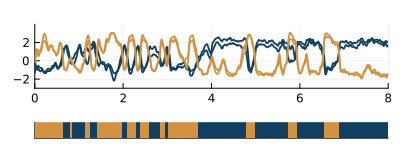

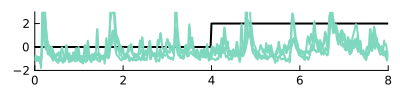

"OLQ"

In [78]:
#########################
###  plot simulation ####
#########################
p1 = plot(title = " ",ytick = -2:2:2, xlim =(0,tspan[2]), ylim = (-3,4))
plot!(sol_EJ_Syn.t,sol_EJ_Syn[id_AVBL,:], label = false, color = clrs_new_order[id_AVBL], linewidth = 1.8) #label = intrinsic_neurons[8]
plot!(sol_EJ_Syn.t,sol_EJ_Syn[id_RIBL,:], label = false, color = clrs_new_order[id_RIBL], linewidth = 1.8) #label = intrinsic_neurons[8]

plot!(sol_EJ_Syn.t,sol_EJ_Syn[id_AVAL,:], label = false, color = clrs_new_order[id_AVAL], linewidth = 1.8) #label = intrinsic_neurons[10]
plot!(sol_EJ_Syn.t,sol_EJ_Syn[id_AVEL,:], label = false, color = clrs_new_order[id_AVEL], linewidth = 1.8) #label = intrinsic_neurons[10]


######### vline for stimulus #######
#vline!([pulse_t1], line=:dash, label = false, linewidth = 1, color = "black")


c1 = palette(:batlow10)|> collect
c1 = c1[2:7]

p2 = heatmap(reshape(behav_ts_sim,(1,:)), c = c1, clim = (-1,1), ytick = false, legend=:none)
plot!(xticks = [])
pall = plot(p1, p2, layout = grid(2, 1, heights=[0.8, 0.2]), size = (400,150)) #size = (400,200)
display(pall)

p3 = plot(t_short, ASH_ts, label = false, linewidth = 2, color = "black",xlim =(0,tspan[2]))
    
# plot!(t_short, ASHL_real_ts, color = rgb_colors_pulse[1], linewidth = 2)
# plot!(t_short, AWCL_real_ts, color = rgb_colors_pulse[1], linewidth = 2)
# plot!(t_short, AWCR_real_ts, color = rgb_colors_pulse[1], linewidth = 2)

# plot!(t_short, ASEL_real_ts, color = rgb_colors_pulse[1], linewidth = 2)
# plot!(t_short, ASER_real_ts, color = rgb_colors_pulse[1], linewidth = 2)

plot!(t_short, OLQDR_real_ts, color = rgb_colors_pulse[1], linewidth = 2)
plot!(t_short, OLQDL_real_ts, color = rgb_colors_pulse[1], linewidth = 2)
plot!(t_short, OLQVR_real_ts, color = rgb_colors_pulse[1], linewidth = 2)
plot!(t_short, OLQVL_real_ts, color = rgb_colors_pulse[1], linewidth = 2)

plot!(ylim = (-2, maximum(ASH_ts)+1), yticks = [-2, 0, 2, 4, 6], grid = false, size = (400,90), legend = false)
display(p3)

##########  save  #########
pulse_neuron_name = "OLQ"   ##  "ASH", "AWC", "ASE", "OLQ"
#pulse_neuron_name = "nopulse"



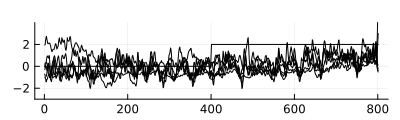

In [80]:
#############################
## plot noise ###############
#############################
p1 = plot(title = " ",ytick = -2:2:2, ylim = (-3, 4), size = (400,120))
p1 = plot!(Dsignals[1:7,:]', color = "black", label = false)

display(p1)
